### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://pennylane.ai/qml/demos/quantum_neural_net.html

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [5]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [6]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [7]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

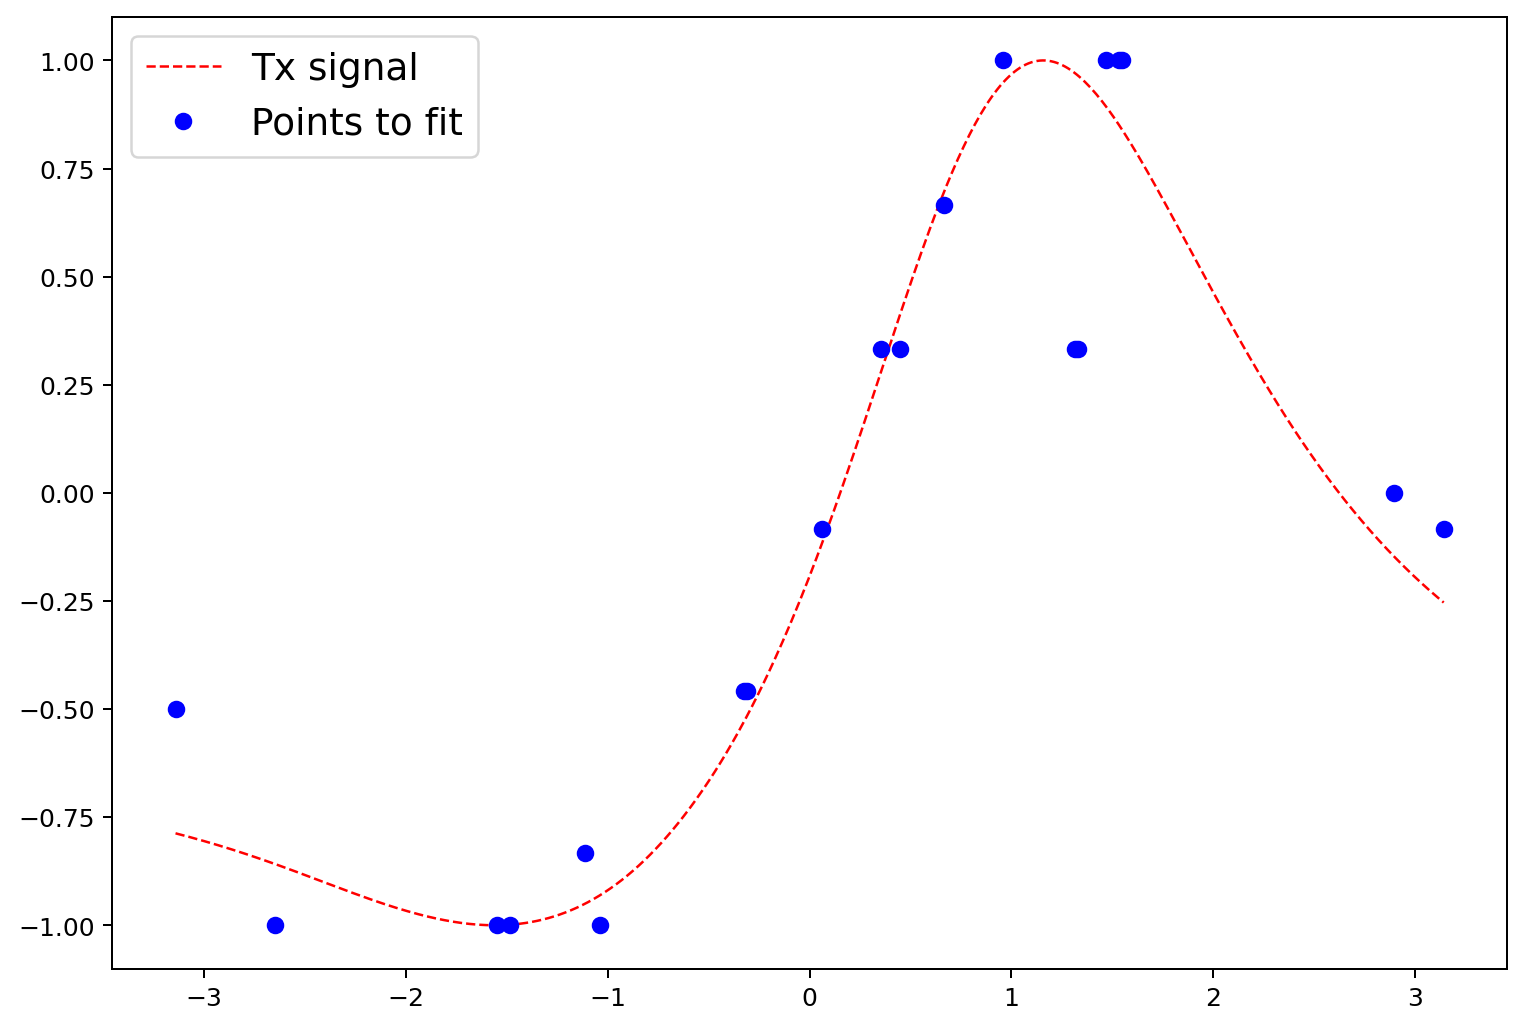

In [22]:
num_samples = 50
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [23]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

In [24]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

In [25]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

In [26]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [27]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

In [28]:
np.random.seed(0)
num_layers = 4
#var_init = 0.005 * np.random.randn(num_layers, 5, requires_grad=True)
var_init = np.random.uniform(high=np.pi, size=(num_layers, 5), requires_grad=True)

print(var_init)

[[1.72414847 2.24683366 1.89363699 1.711801   1.33095081]
 [2.0291362  1.37472077 2.80158751 3.02743585 1.20461706]
 [2.48727756 1.66157239 1.78456462 2.9078476  0.22316636]
 [0.27372477 0.06351797 2.61575239 2.44465153 2.73322377]]


In [29]:
X_data = np.array(X.numpy()[:, 0], requires_grad=False)
y_data = np.array(y.numpy()[:, 0], requires_grad=False)

In [30]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

cost_plot = []
var = var_init
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X_data, y_data)
    cost_plot.append(_cost)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.5134790 
Iter:     1 | Cost: 0.5145223 
Iter:     2 | Cost: 0.5154580 
Iter:     3 | Cost: 0.5145795 
Iter:     4 | Cost: 0.5142592 
Iter:     5 | Cost: 0.5126661 
Iter:     6 | Cost: 0.5149447 
Iter:     7 | Cost: 0.5145261 
Iter:     8 | Cost: 0.5150383 
Iter:     9 | Cost: 0.5125520 
Iter:    10 | Cost: 0.5134730 
Iter:    11 | Cost: 0.5129855 
Iter:    12 | Cost: 0.5147861 
Iter:    13 | Cost: 0.5117050 
Iter:    14 | Cost: 0.5142761 
Iter:    15 | Cost: 0.5138094 
Iter:    16 | Cost: 0.5156645 
Iter:    17 | Cost: 0.5144744 
Iter:    18 | Cost: 0.5127728 
Iter:    19 | Cost: 0.5157455 
Iter:    20 | Cost: 0.5126842 
Iter:    21 | Cost: 0.5124611 
Iter:    22 | Cost: 0.5126971 
Iter:    23 | Cost: 0.5141181 
Iter:    24 | Cost: 0.5142184 
Iter:    25 | Cost: 0.5110805 
Iter:    26 | Cost: 0.5092128 
Iter:    27 | Cost: 0.5132916 
Iter:    28 | Cost: 0.5111989 
Iter:    29 | Cost: 0.5151236 
Iter:    30 | Cost: 0.5119259 
Iter:    31 | Cost: 0.5128667 
Iter:   

Iter:   265 | Cost: 0.5138378 
Iter:   266 | Cost: 0.5138450 
Iter:   267 | Cost: 0.5119553 
Iter:   268 | Cost: 0.5143399 
Iter:   269 | Cost: 0.5131627 
Iter:   270 | Cost: 0.5134204 
Iter:   271 | Cost: 0.5138158 
Iter:   272 | Cost: 0.5139063 
Iter:   273 | Cost: 0.5130346 
Iter:   274 | Cost: 0.5133603 
Iter:   275 | Cost: 0.5134997 
Iter:   276 | Cost: 0.5122698 
Iter:   277 | Cost: 0.5140660 
Iter:   278 | Cost: 0.5128887 
Iter:   279 | Cost: 0.5112202 
Iter:   280 | Cost: 0.5130557 
Iter:   281 | Cost: 0.5132858 
Iter:   282 | Cost: 0.5141538 
Iter:   283 | Cost: 0.5129742 
Iter:   284 | Cost: 0.5141557 
Iter:   285 | Cost: 0.5144985 
Iter:   286 | Cost: 0.5140724 
Iter:   287 | Cost: 0.5128699 
Iter:   288 | Cost: 0.5135902 
Iter:   289 | Cost: 0.5130410 
Iter:   290 | Cost: 0.5144704 
Iter:   291 | Cost: 0.5143099 
Iter:   292 | Cost: 0.5141472 
Iter:   293 | Cost: 0.5132134 
Iter:   294 | Cost: 0.5145385 
Iter:   295 | Cost: 0.5128230 
Iter:   296 | Cost: 0.5130770 
Iter:   

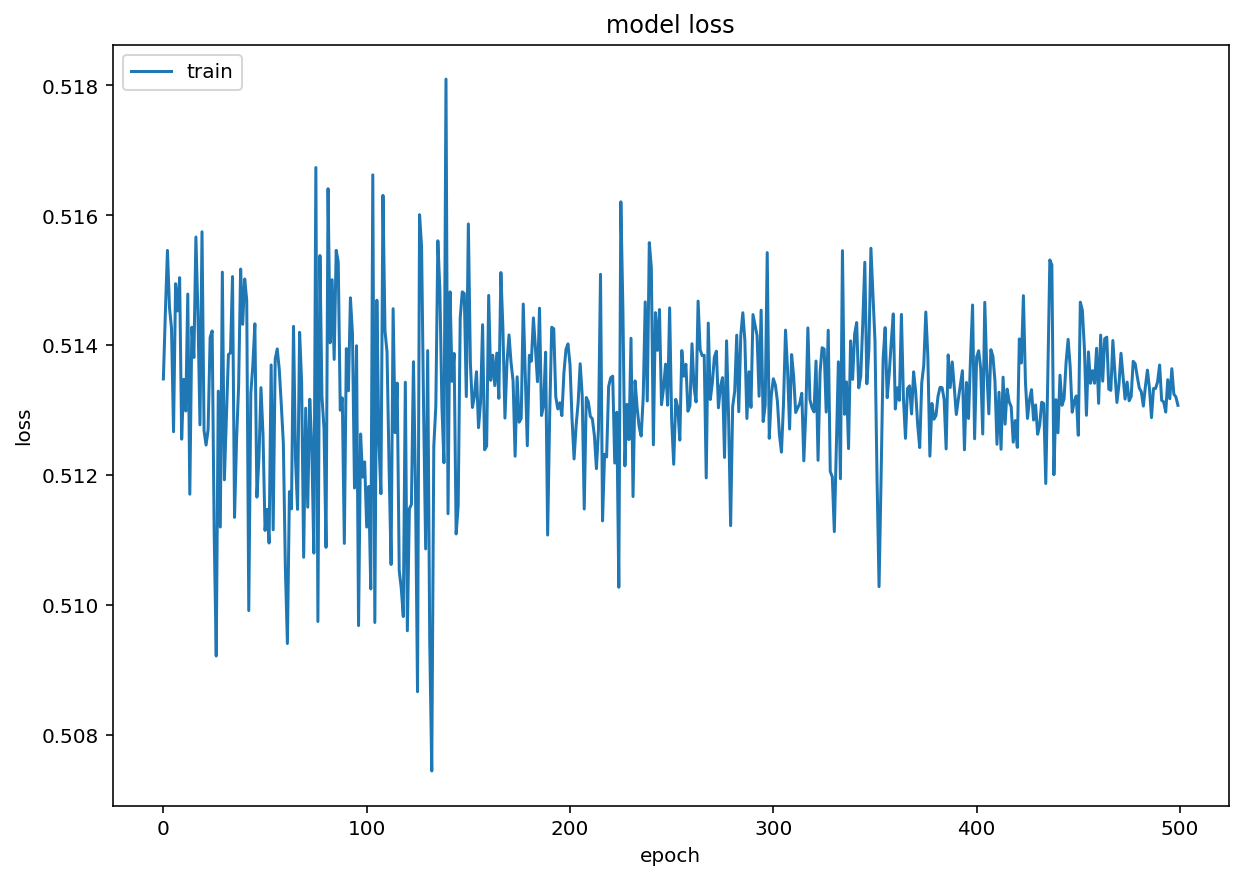

In [31]:
# summarize history for loss
plt.plot(cost_plot)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [32]:
X_pred = X_.numpy()[:,0]

In [33]:
X_.shape

(450, 1)

In [34]:
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]

In [35]:
np.array(y_predict).shape

(450,)

In [36]:
y_predict_smooth = smooth(y_predict)

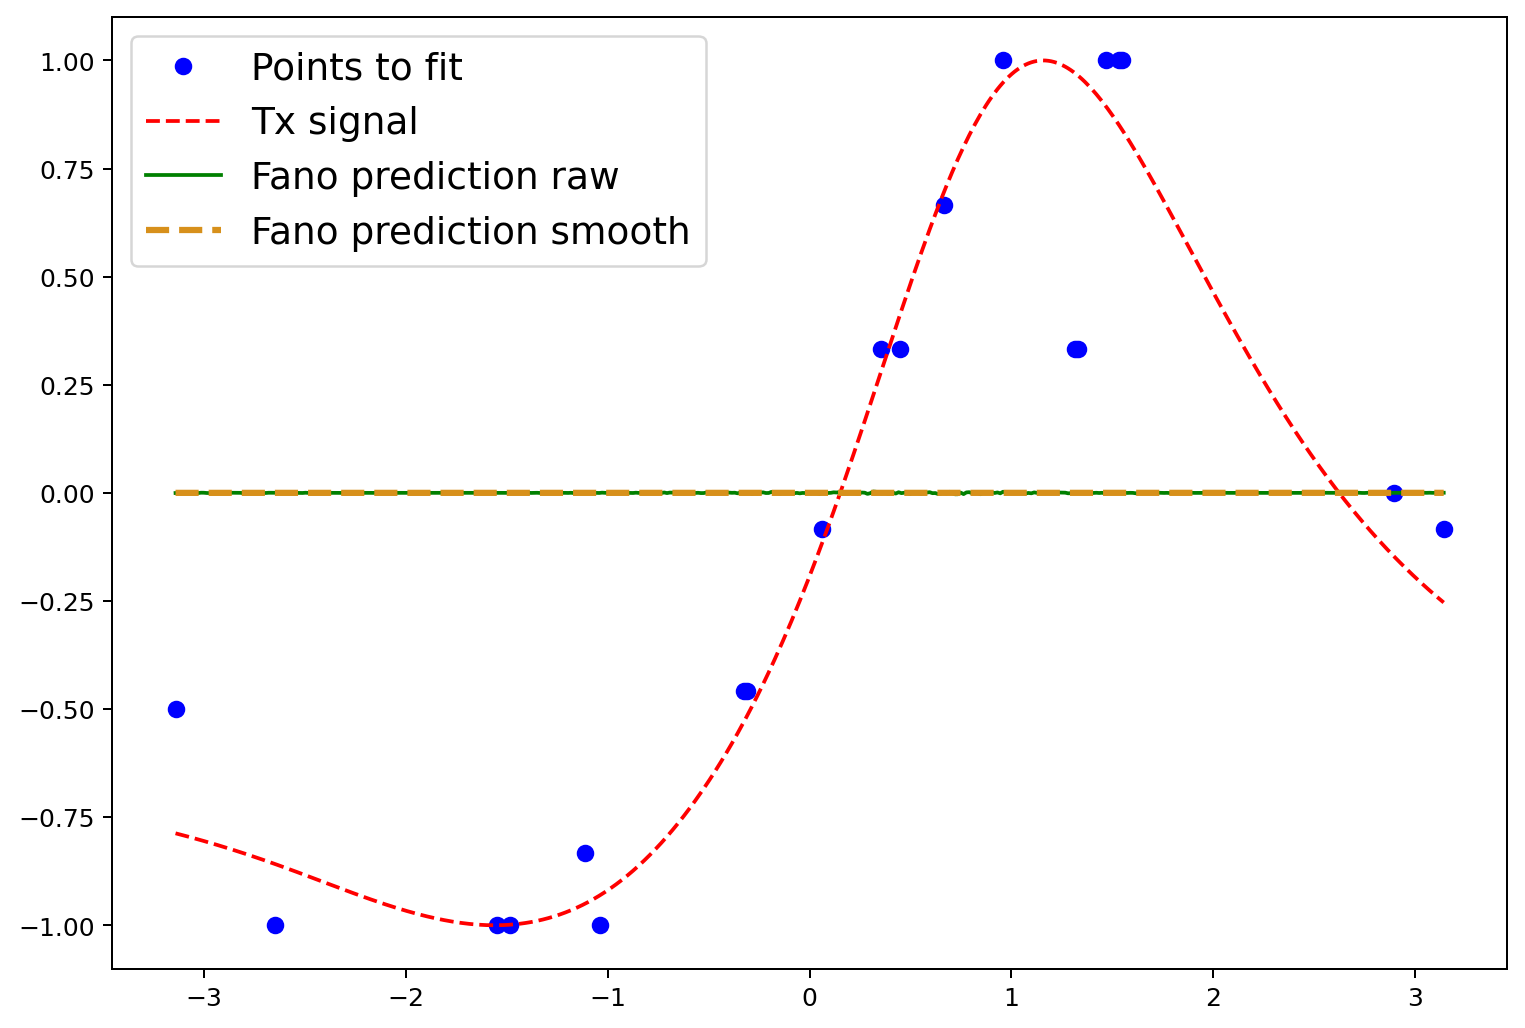

In [37]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [38]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright